# **Ex5-2**: IoU & NMS (Practice)

## (Optional) Prepare PASCAL VOC2007 dataset.

In [1]:
## Ex5-1을 통해 PASCAL VOC2007 dataset을 다운로드 받았다면, 다시 다운로드 받지 않아도 됩니다.
## link: https://drive.google.com/file/d/1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT/view?usp=sharing
## id: 1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT
## filename: VOC2007.zip
## wget error 시, PLMS 에서 직접 다운로드 후 업로드 부탁드립니다: VOC2007.zip 을 업로드 한 뒤 !unzip VOC2007.zip 실행.

# 다운로드를 위해서는 아래 명령문들을 주석 해제 해주세요.
# !apt-get update -y
# !apt-get install wget unzip -y
# !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT" -O VOC2007.zip && rm -rf ~/cookies.txt
# !unzip VOC2007.zip
# !rm VOC2007.zip

## 1. Import packages.

In [2]:
%matplotlib inline
# %matplotlib notebook
import os
import numpy as np
import scipy.io as sio
import pickle
import torch
import torch.utils.data as data
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms


### Funtion for visualization
def draw_bb(img, boxes, color='r'):
    fig,ax = plt.subplots(1)
    for box in boxes:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()
### Fuction for vislualize boudning with two differnt colors
def draw_bb2(img, boxes1, boxes2, color1='r', color2='g'):
    fig,ax = plt.subplots(1)
    for box in boxes1:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color1,facecolor='none')
        ax.add_patch(rect)
    for box in boxes2:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color2,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

## 2. PASCAL VOC2007 Dataset

In [3]:
class PASCAL_DATASET(data.Dataset):
    def __init__(self, data_root, img_list_file):        
        self.data_root = data_root        
        self.img_list = []
        self._load_img_name_list(img_list_file)               

    def _load_img_name_list(self, img_list_file):
        with open(img_list_file) as f:
            self.img_list = f.read().splitlines()
                                  
    def _load_annotation(self, img_path):
        filename = os.path.join(self.data_root, 'Annotations', img_path + '.xml')
        tree = ET.parse(filename)
        objs = tree.findall('object')
        num_objs = len(objs)
        boxes = np.zeros((num_objs, 4), dtype=np.int32)
        gt_classes_str = []
        
        for ix, obj in enumerate(objs):
            bbox = obj.find('bndbox')
            # Make pixel indexes 0-based
            x1 = float(bbox.find('xmin').text) - 1
            y1 = float(bbox.find('ymin').text) - 1
            x2 = float(bbox.find('xmax').text) - 1
            y2 = float(bbox.find('ymax').text) - 1
            gt_classes_str.append(obj.find('name').text)
            boxes[ix, :] = [x1, y1, x2, y2]

        return boxes, gt_classes_str
                                      
    def __len__(self,):
        return len(self.img_list)

    def __getitem__(self, index):
        img_path = self.img_list[index]
        img = Image.open(os.path.join(self.data_root, 'JPEGImages', img_path + '.jpg'))
        boxes, gt_classes_str = self._load_annotation(img_path)
        return img, boxes, gt_classes_str

In [38]:
pascal_data = PASCAL_DATASET(data_root='./VOC2007/',img_list_file='./VOC2007/ImageSets/Main/train.txt')

In [39]:
pascal_it = iter(pascal_data)
img, gt_boxes, gt_box_classes = next(pascal_it)

[[155  96 350 269]]


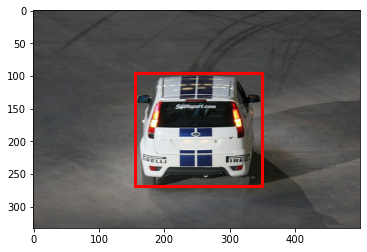

In [40]:
print(gt_boxes)
draw_bb(img, gt_boxes)

## 3. Calculate IoU!

In [41]:
### Our ground truth box
print(gt_boxes)
print(gt_boxes.shape)

[[155  96 350 269]]
(1, 4)


In [42]:
### Assume we have following predictions from network
predicted_boxes = np.zeros((5, 4), dtype=np.int32)
predicted_boxes[0, :] = [100, 80, 320, 240]
predicted_boxes[1, :] = [50, 40, 160, 120]
predicted_boxes[2, :] = [200, 150, 300, 300]
predicted_boxes[3, :] = [250, 50, 450, 250]
predicted_boxes[4, :] = [195, 145, 295, 295]
predicted_scores = np.array([0.9, 0.8, 0.7, 0.6, 0.4])
print(predicted_boxes)
print(predicted_boxes.shape)

[[100  80 320 240]
 [ 50  40 160 120]
 [200 150 300 300]
 [250  50 450 250]
 [195 145 295 295]]
(5, 4)


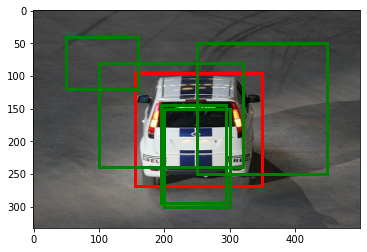

In [43]:
draw_bb2(img, gt_boxes, predicted_boxes)

In [44]:
## Convert to pytorch tensors
gt_boxes = torch.from_numpy(gt_boxes).float()
predicted_boxes = torch.from_numpy(predicted_boxes).float()
predicted_scores = torch.from_numpy(predicted_scores).float()
print(predicted_boxes.shape)

torch.Size([5, 4])


In [15]:
def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes 
    box 1 : (1, 4) shaped pytorch tensors - sinlge GT bounding box
    box 2 : (N, 4) shaped pytorch tensors - multiple predictions from network
    return -> iou: (N,)
    """
    # (x1, y1) -------------------------
    #          |                       |
    #          |                       |
    #          |                       |
    #          ------------------------- (x2, y2)
    # bbox: (x1, y1, x2, y2)
    # area = (x2 - x1) * (y2 - y1)
    # Implement: calculate IoU (= Intersection over Union)
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
    # intersection
    inter_rec_x1 = torch.max(b1_x1, b2_x1)
    inter_rec_y1 = torch.max(b1_y1, b2_y1)
    inter_rec_x2 = torch.min(b1_x2, b2_x2)
    inter_rec_y2 = torch.min(b1_y2, b2_y2)
    
    # inter area
    inter_area = (torch.clamp(inter_rec_x2 - inter_rec_x1, min=0)) \
                  * (torch.clamp(inter_rec_y2 - inter_rec_y1, min=0))
                  
    # union
    area_1 = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    area_2 = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    
    # IoU
    iou = inter_area / (area_1 + area_2 - inter_area + 1e-6)
    return iou

In [16]:
### Get iou score for each prediction boxes
ious = bbox_iou(gt_boxes, predicted_boxes)
print(ious)

tensor([0.5260, 0.0028, 0.3231, 0.2640])


tensor([ 50.,  40., 160., 120.])


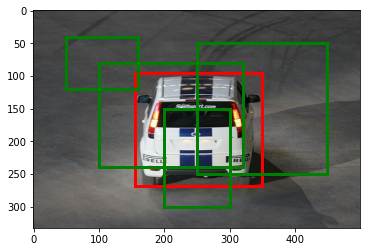

In [18]:
print(predicted_boxes[1])
draw_bb2(img, gt_boxes, predicted_boxes)

In [19]:
print(ious)
print(predicted_boxes)

tensor([0.5260, 0.0028, 0.3231, 0.2640])
tensor([[100.,  80., 320., 240.],
        [ 50.,  40., 160., 120.],
        [200., 150., 300., 300.],
        [250.,  50., 450., 250.]])


In [24]:
# Anchor label assignment
pos_threshold = 0.5
neg_threshold = 0.3
ignore_label = 255

anchor_labels = ignore_label * torch.ones((4,), dtype=torch.int64)
print(anchor_labels)
anchor_labels[ious > pos_threshold] = 1
anchor_labels[ious < neg_threshold] = 0
print(anchor_labels)
print(ious)

tensor([255, 255, 255, 255])
tensor([  1,   0, 255,   0])
tensor([0.5260, 0.0028, 0.3231, 0.2640])


## 4. Threshold bounding boxes based on IoU scores

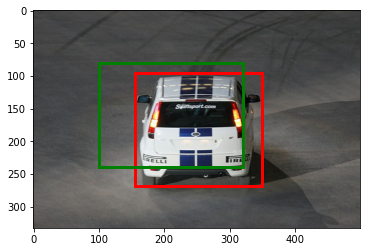

In [26]:
threshold = 0.5
th = np.where(ious.numpy() > threshold)
th_boxes = predicted_boxes[th]
draw_bb2(img, gt_boxes, th_boxes)

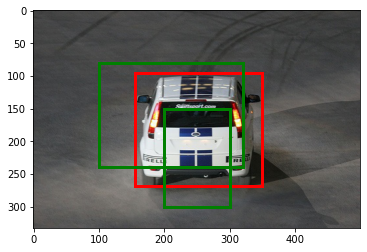

In [27]:
threshold = 0.3
th = np.where(ious.numpy() > threshold)
th_boxes = predicted_boxes[th]
draw_bb2(img, gt_boxes, th_boxes)

## 5. Non-maximum suppression (NMS)

In [47]:
def nms(boxes, scores, threshold):
    """
    boxes: (N, 4), each row-> (x1, y1, x2, y2), x2 > x1, y2 > y1
    scores: (N,), each value in [0, 1]
    threshold: iou threshold
    
    return: List[box]
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort() # (0, 1, 2,..., N-1) -> (N-3, ..., 5)
    keep = []

    while len(order) > 0:
        # Hint: torch.index_select
        # boxes = torch.index_select(boxes, dim=0, index=order)
        idx = order[-1]
        keep.append(boxes[idx])
        order = order[:-1] # (N-1,)
        
        if len(order) == 0:
            break # check
            
        xx1 = torch.index_select(x1, dim=0, index=order)
        xx2 = torch.index_select(x2, dim=0, index=order)
        yy1 = torch.index_select(y1, dim=0, index=order)
        yy2 = torch.index_select(y2, dim=0, index=order)
        
        # intersection
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
        
        inter = torch.clamp(xx2 - xx1, min=0) * torch.clamp(yy2 - yy1, min=0)
        rem_areas = torch.index_select(areas, dim=0, index=order)
        iou = inter / (rem_areas - inter + areas[idx])
        
        # mask
        mask = iou < threshold
        order = order[mask]
        
    return torch.vstack(keep)

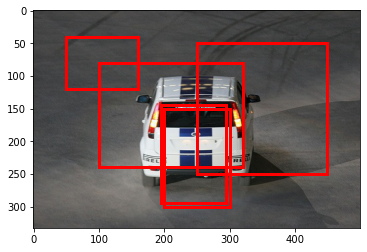

In [48]:
draw_bb(img, predicted_boxes)

In [52]:
nms_boxes = nms(predicted_boxes, predicted_scores, 0.2)
print(nms_boxes)

tensor([[100.,  80., 320., 240.],
        [ 50.,  40., 160., 120.],
        [250.,  50., 450., 250.]])


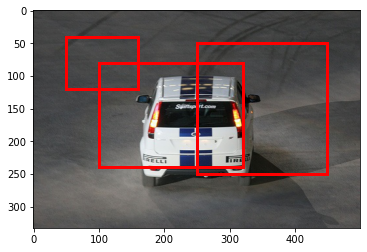

In [53]:
draw_bb(img, nms_boxes)